In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def get_data_split(data_df, selected_columns, target_label):
    df_processed = data_df[selected_columns].reset_index(drop=True)
    input_feat = list(set(selected_columns).difference({target_label}))

    df_x = df_processed[input_feat].reset_index(drop=True)
    df_y = df_processed[target_label]

    transfer = MinMaxScaler(feature_range=(0, 1))

    # normalization
    df_x = transfer.fit_transform(df_x)

    return train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [2]:
import pandas as pd
import numpy as np

sun_data_df = pd.read_csv('dataset_processed.csv')

df_with_location_en = pd.get_dummies(sun_data_df, columns=['Location'], drop_first=True)
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)

# Only data between 10 a.m. and 3 p.m. is available
# excluding periods when no power generation will occur
min_hour_of_interest = 10
max_hour_of_interest = 15

df_with_loc_season_en['delta_hr'] = df_with_loc_season_en.Hour - min_hour_of_interest

# There is a perfect correlation between the cosine of the date characteristic and its actual value (month and hour)
df_with_loc_season_en['sine_mon'] = np.sin((df_with_loc_season_en.Month - 1) * np.pi / 11)
df_with_loc_season_en['cos_mon'] = np.cos((df_with_loc_season_en.Month - 1) * np.pi / 11)

df_with_loc_season_en['sine_hr'] = np.sin(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr'] = np.cos(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))

selected_columns = ['Latitude', 'Humidity', 'Temp', 'power_class', 'Wind',
                    'Visibility', 'Pressure', 'Cloud', 'Location_Grissom',
                    'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                    'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                    'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                    'Location_USAFA', 'Season_Spring', 'Season_Summer', 'Season_Winter',
                    'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

x_train, x_test, y_train, y_test = get_data_split(df_with_loc_season_en, selected_columns, 'power_class')

print(len(x_train), len(x_test))

16836 4209


In [3]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dt = DecisionTreeClassifier(random_state=24)
dt = dt.fit(x_train, y_train)

print("accuracy:", dt.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test), y_test, average='weighted'))

# It is obviously an overfitting model
# its performance on the training set is significantly better than that on the test set

accuracy: 0.5573770491803278
train f1_score: 1.0
test f1_score: 0.5554638425779117


In [4]:
# Changing the depth of the tree helps prevent overfitting

dt = DecisionTreeClassifier(max_depth=3, random_state=24)
dt = dt.fit(x_train, y_train)

print("accuracy:", dt.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test), y_test, average='weighted'))

accuracy: 0.4492753623188406
train f1_score: 0.538967137808641
test f1_score: 0.5518539105321666


Text(0.5, 1.0, 'Scores at different depths')

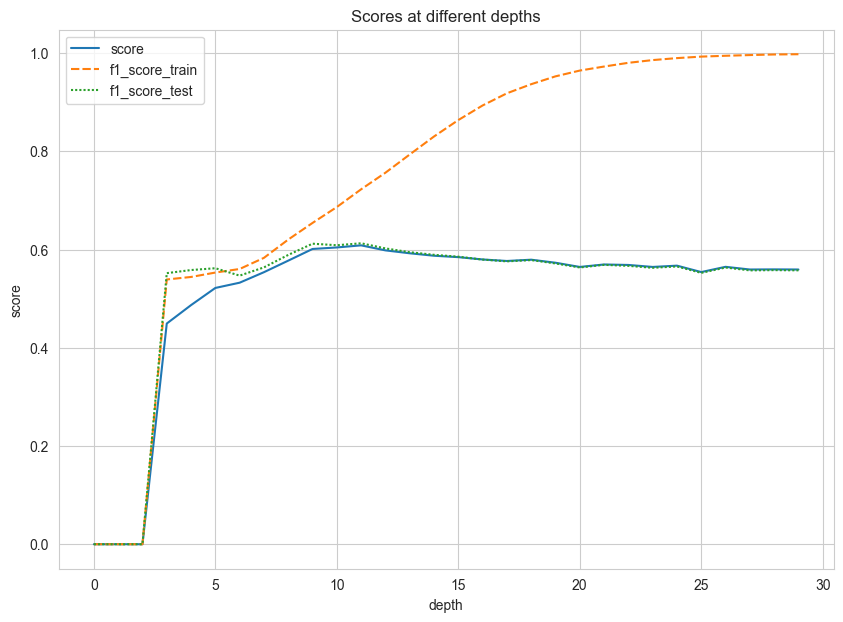

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

depths = range(3, 30)
score = np.zeros(30)
f1_score_train = np.zeros(30)
f1_score_test = np.zeros(30)
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=24)
    dt.fit(x_train, y_train)
    score[depth] = dt.score(x_test, y_test)
    f1_score_train[depth] = metrics.f1_score(dt.predict(x_train), y_train, average='weighted')
    f1_score_test[depth] = metrics.f1_score(dt.predict(x_test), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test})
sns.lineplot(data=data)
plt.xlabel("depth")
plt.ylabel("score")
plt.title("Scores at different depths")

In [6]:
# It can be clearly seen from the above figure that as the depth of the tree increases
# the performance gap between the test set and the training set becomes larger and larger
# So take max_ depth=6

dt = DecisionTreeClassifier(max_depth=6, random_state=24)
dt.fit(x_train, y_train)

print("accuracy:", dt.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test), y_test, average='weighted'))

accuracy: 0.5324305060584462
train f1_score: 0.5603333508874698
test f1_score: 0.5468113588011567


Text(0.5, 1.0, 'scores at different min_weight_fraction_leaf')

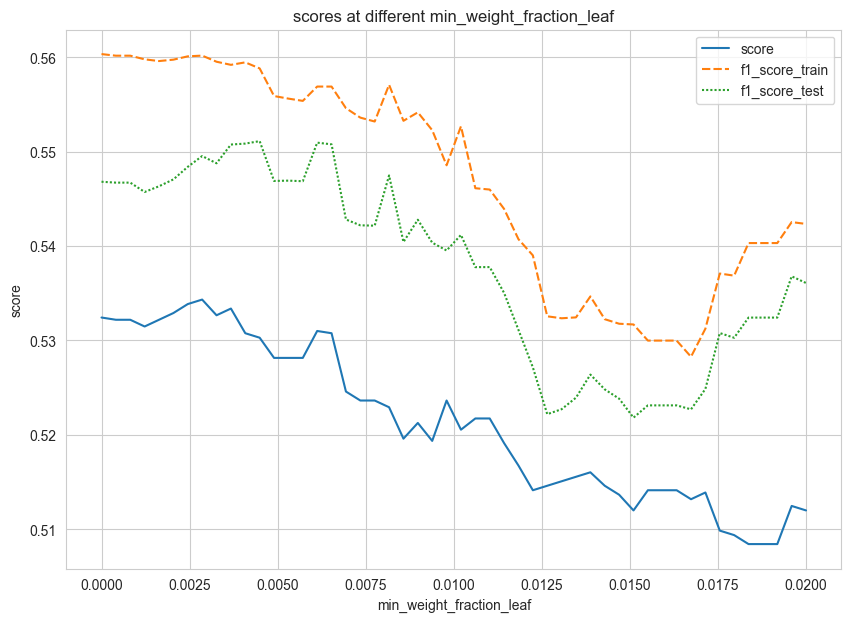

In [7]:
# Exploring the selection of min_weight_fraction_leaf

min_weight_fraction = np.linspace(0, 0.02, 50, endpoint=True)
fraction_score = np.zeros(50)
f1_score_test = np.zeros(50)
f1_score_train = np.zeros(50)
i = 0
for min_weight in min_weight_fraction:
    dt = DecisionTreeClassifier(max_depth=6, min_weight_fraction_leaf=min_weight, random_state=24)
    dt.fit(x_train, y_train)

    fraction_score[i] = dt.score(x_test, y_test)
    f1_score_train[i] = metrics.f1_score(dt.predict(x_train), y_train, average='weighted')
    f1_score_test[i] = metrics.f1_score(dt.predict(x_test), y_test, average='weighted')
    i = i + 1

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": fraction_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=min_weight_fraction)
sns.lineplot(data=data)
plt.xlabel("min_weight_fraction_leaf")
plt.ylabel("score")
plt.title("scores at different min_weight_fraction_leaf")

# Can see that it is better to set this weight to 0, and the default value of model is also 0

Text(0.5, 1.0, 'scores at different n_components')

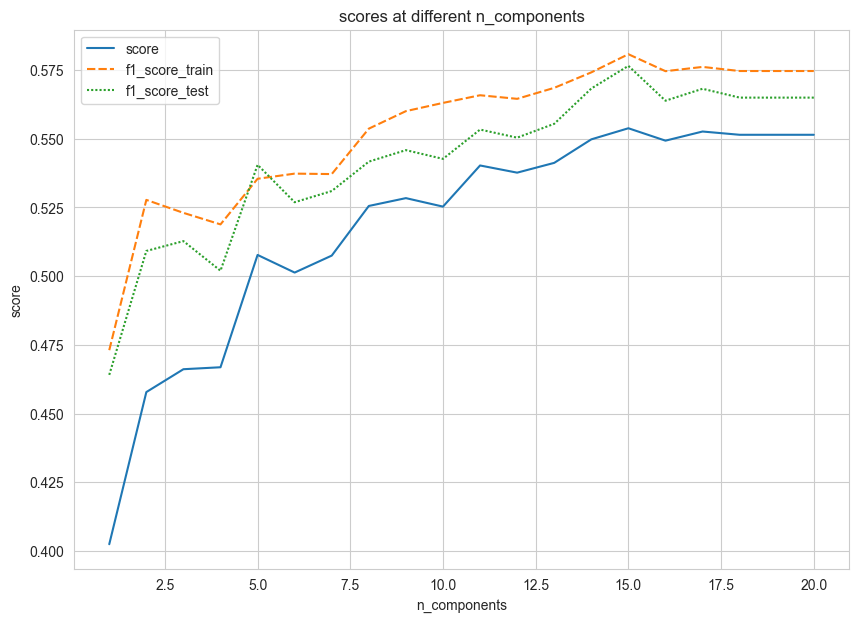

In [8]:
# PCA

from sklearn.decomposition import PCA

pca_score = np.zeros(20)
f1_score_test = np.zeros(20)
f1_score_train = np.zeros(20)

for i in range(1, 21):
    j = i - 1
    pca = PCA(n_components=i, random_state=24)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    dt = DecisionTreeClassifier(max_depth=6, random_state=24)
    dt.fit(x_train_pca, y_train)

    pca_score[j] = dt.score(x_test_pca, y_test)

    f1_score_train[j] = metrics.f1_score(dt.predict(x_train_pca), y_train, average='weighted')
    f1_score_test[j] = metrics.f1_score(dt.predict(x_test_pca), y_test, average='weighted')

plt.figure(figsize=(10, 7))
data = pd.DataFrame({"score": pca_score, "f1_score_train": f1_score_train, "f1_score_test": f1_score_test},
                    index=range(1, 21))
sns.lineplot(data=data)
plt.xlabel("n_components")
plt.ylabel("score")
plt.title("scores at different n_components")

In [9]:
# from the result of PCA performance, take n_components=15

pca = PCA(n_components=15, random_state=24)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
dt = DecisionTreeClassifier(max_depth=6, random_state=24)
dt.fit(x_train_pca, y_train)

print("accuracy:", dt.score(x_test_pca, y_test))

print("train f1_score:", metrics.f1_score(dt.predict(x_train_pca), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(dt.predict(x_test_pca), y_test, average='weighted'))

accuracy: 0.5538132573057734
train f1_score: 0.5807479772371719
test f1_score: 0.5765097184159866
